**ФИО:**


Задание: создать модель для решения задачи прогнозирования временных рядов с использованием фреймворка Keras.

В этой работе булем решать задачу прогнозирования временных рядов с использованием фреймворка Keras.. В ноутбуке ниже приведен пример создания нейронной сети для прогнозирования курса акций.

В задании для самостоятельной разработки необходимо загрузить датасет и создать 3 архитектуры сети (MLP, Conv1D> LSTM).


**Основные понятия статистического анализа временных рядов:**

**Тренд** - компонента, описывающая долгосрочное изменение уровня ряда.

**Сезонность** - компонента, обозначаемая как Q, описывает циклические изменения уровня ряда.

**Ошибка **(random noise) - непрогнозируемая случайная компонента, описывает нерегулярные изменения в данных, необъяснимые другими компонентами.

**Автокорреляция** -статистическая взаимосвязь между последовательностями величин одного ряда. Это один из самых важных коэффициентов в анализе временного ряда. Чтобы посчитать автокорреляцию, используется корреляция между временным рядом и её сдвинутой копией от величины временного сдвига. Сдвиг ряда называется лагом.

**Автокорреляционная функция**- график автокорреляции при разных лагах.

**Стационарный ряд** - ряд, в котором свойства не зависят от времени. При таких компонентах ряда, как тренд или сезонность, ряд не является стационарным. Это интуитивное понятие. На практике есть два вида стационарности - строгая и слабая. В следующих алгоритмах, нам достаточно слабой. Она заключается в постоянной дисперсии (без гетероскедастичности) и в постоянности среднего значения ряда.



In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gdown
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [ ]:
base_data = pd.read_csv('18_19.csv', sep=';')
base_data.head()

In [ ]:
data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [ ]:
d = data18_19

In [ ]:
data = pd.concat([data16_17, data18_19]).to_numpy() # Объединение файлов


In [ ]:
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}

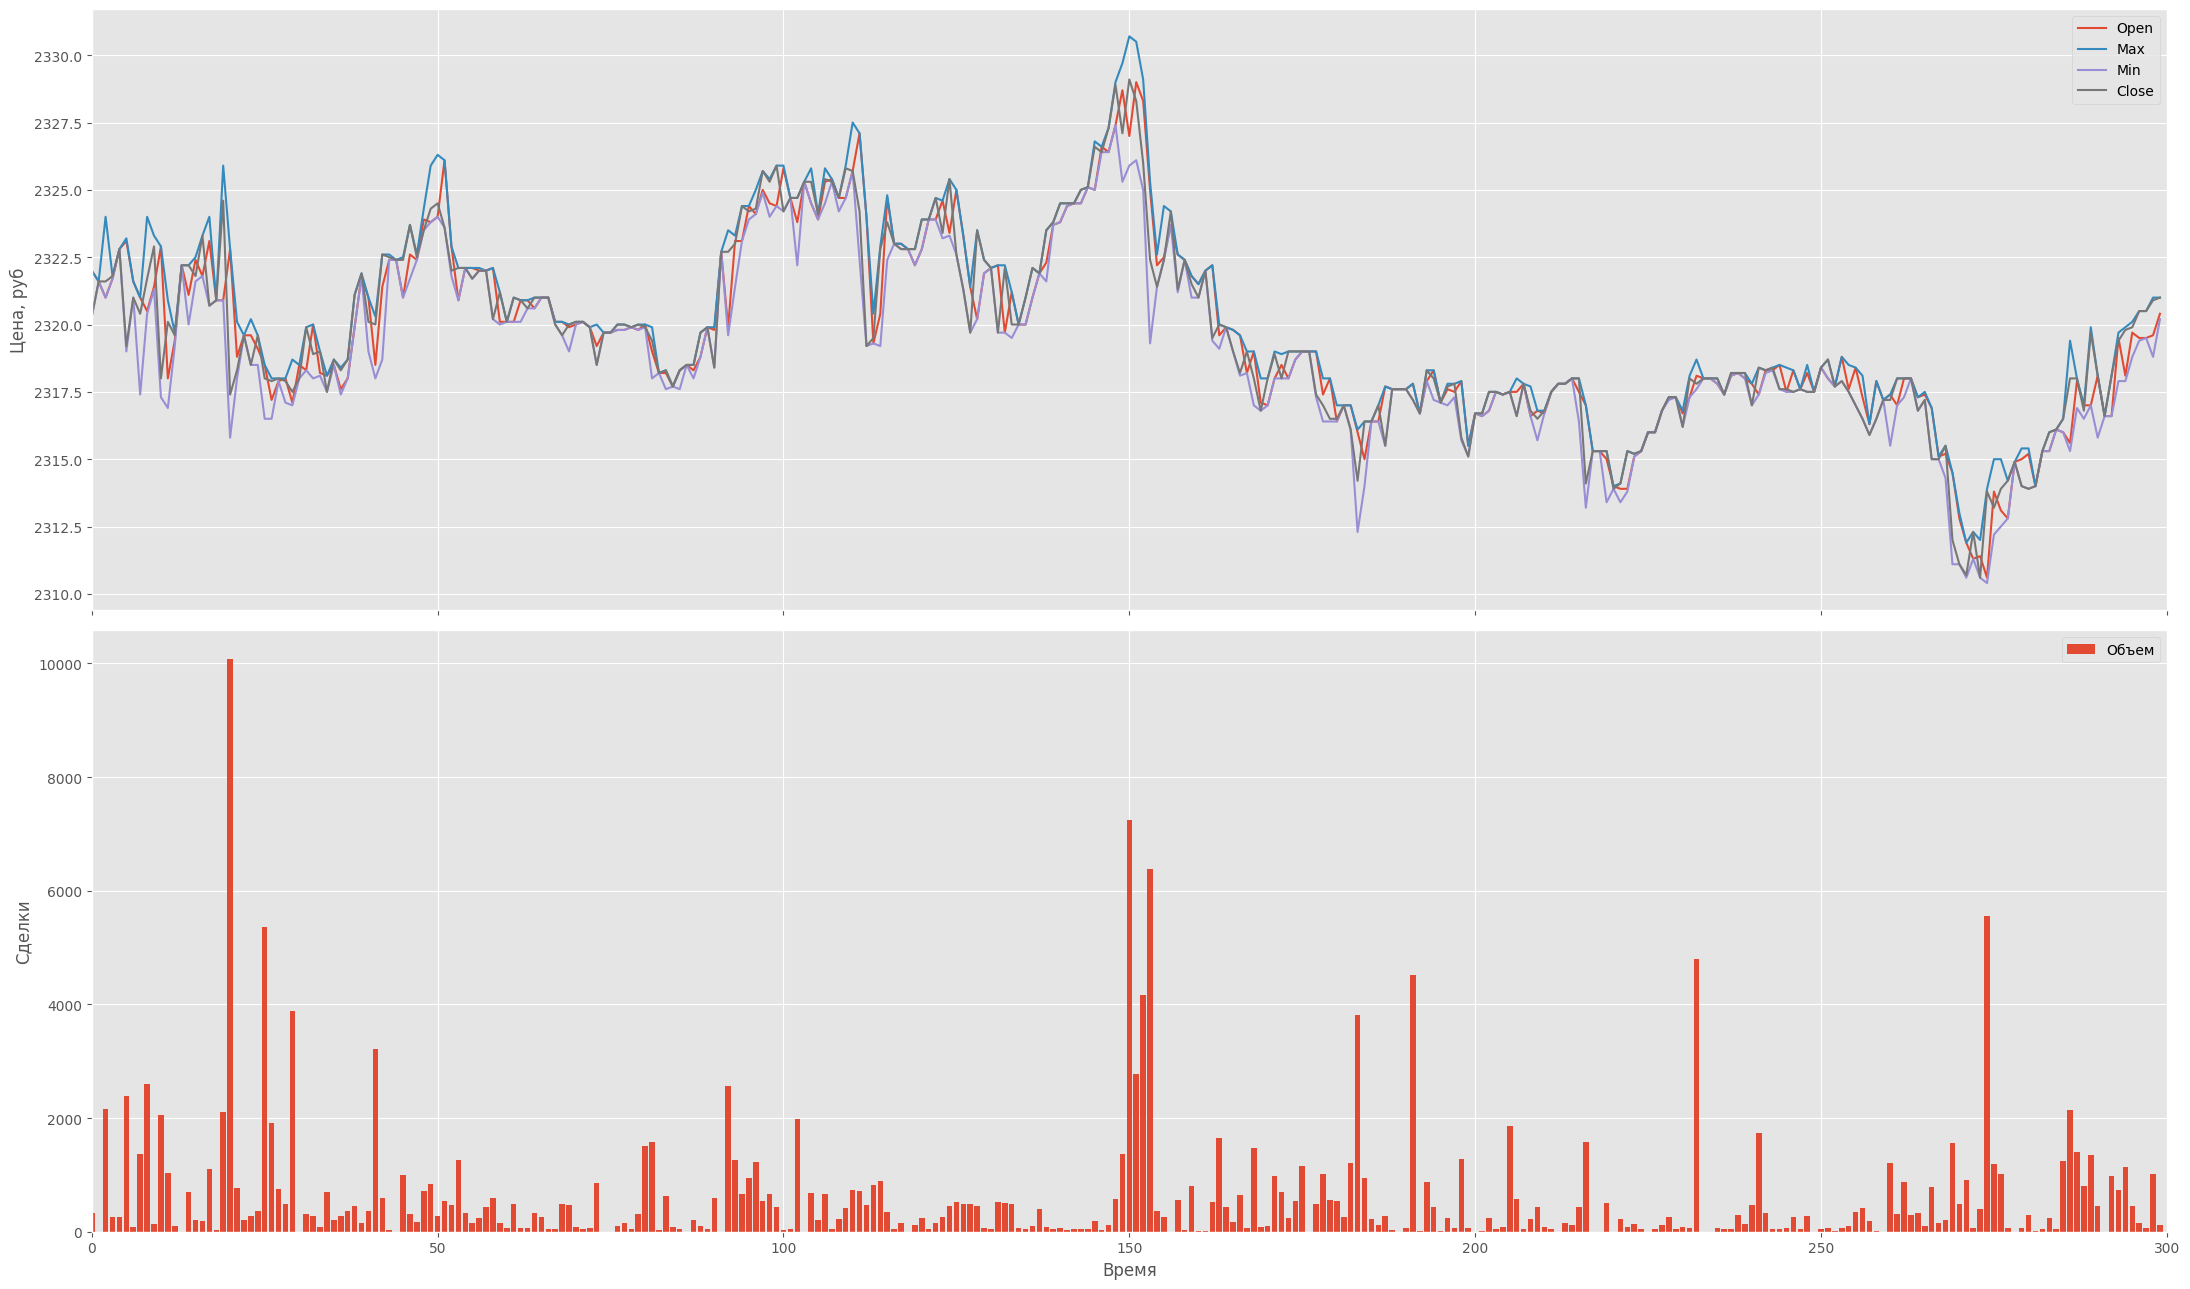

In [ ]:
start = 100
length = 300
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 13), sharex=True)
for chn in range(4):

    ax1.plot(data[start:start + length, chn],
             label=CHANNEL_NAMES[chn])
ax1.set_ylabel('Цена, руб')
ax1.legend()
# Канал volume (объем)
ax2.bar(x=np.arange(length),
        height=data[start:start + length, CHANNEL_INDEX['Volume']],
        label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()
plt.xlabel('Время')
# Регулировка пределов оси x
plt.xlim(0, length)
plt.tight_layout()
plt.show()

In [ ]:
# Словарь каналов данных с их индексами
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


In [ ]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                           # Объем батча для генератора
TEST_LEN = 30000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (451872, 5), (451872, 1)
Test  data: (29400, 5), (29400, 1)
Train batch x: (20, 300, 5), y: (20, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (29100, 300, 5), y: (29100, 1)


In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и денормализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [ ]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

In [ ]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
# Функция построения графиков корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''): # список имен каналов данных

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)

    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
def eval_net(model,
             x_test, y_test,
             y_scaler,
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    show_corr(y_pred, y_true, back_steps_max=back_steps_max,
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [ ]:

def train_eval_net(model,
                   train_datagen, val_datagen,
                   epoch_list,
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    model.summary()

    for epochs, opt in epoch_list:
        model.compile(loss='mse', optimizer=opt)
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300, 150)          900       
                                                                 
 flatten (Flatten)           (None, 45000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 45001     
                                                                 
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________
Обучение 10 эпох
Epoch 1/10
22579/22579 [==============================] - 221s 10ms/step - loss: 6.0441e-04 - val_loss: 2.2555e-05
Epoch 2/10
22579/22579 [==============================] - 214s 9ms/step - loss: 5.8149e-05 - val_loss: 1.9392e-05
Epoch 3/10
22579/22579 [==============================] - 216s 10ms/st

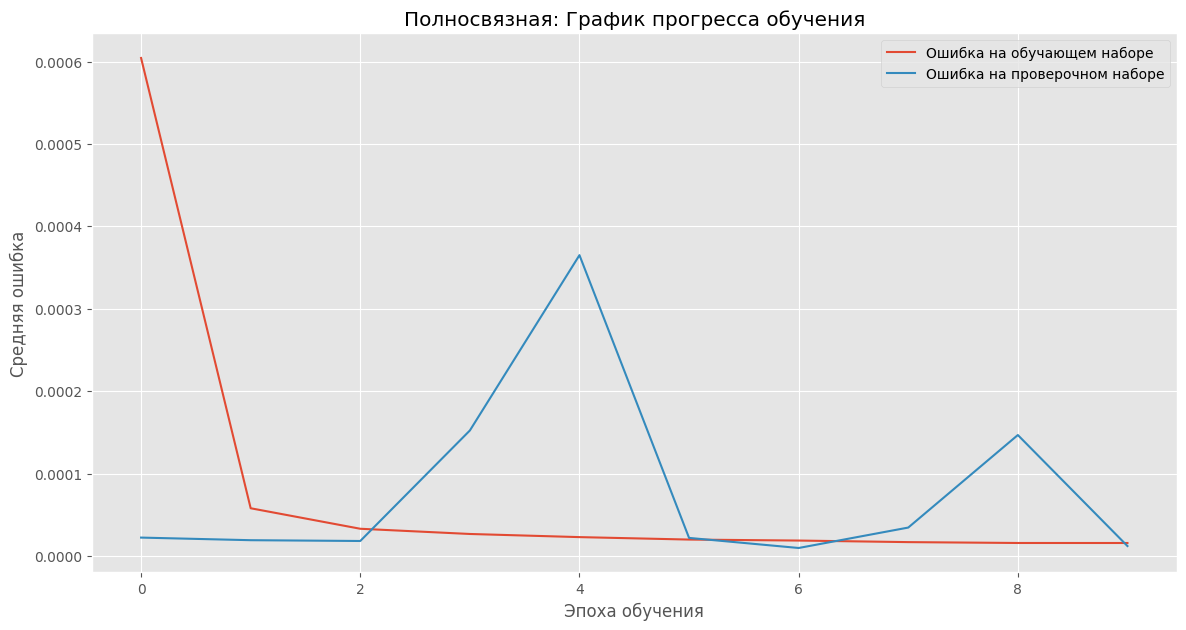

910/910 [==============================] - 5s 5ms/step


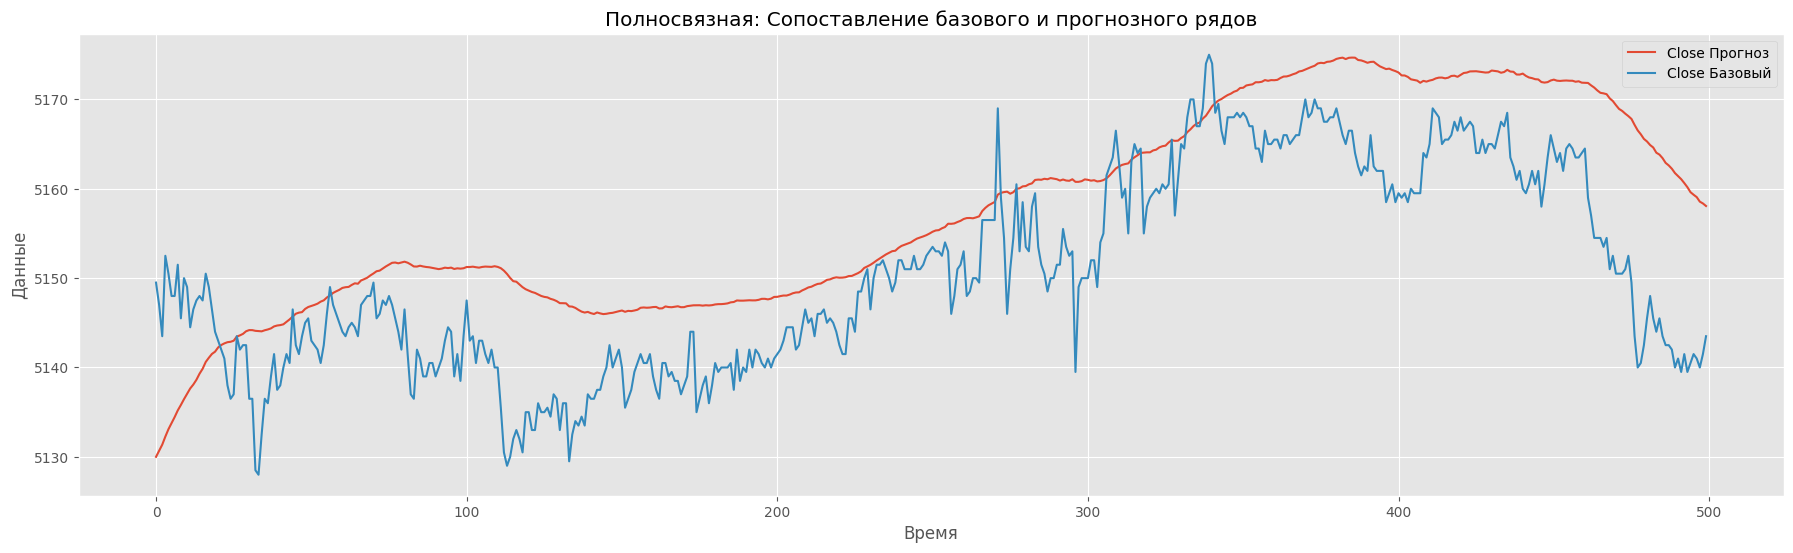

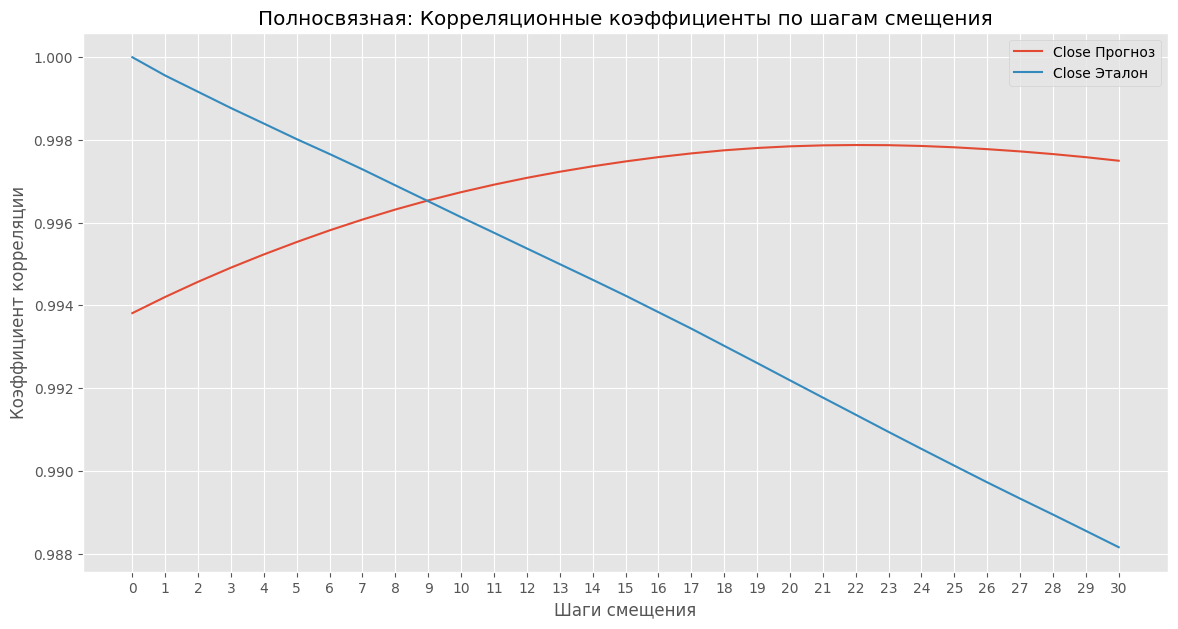

Обучение 25 эпох
Epoch 1/25
22579/22579 [==============================] - 229s 10ms/step - loss: 5.4703e-06 - val_loss: 8.1952e-06
Epoch 2/25
22579/22579 [==============================] - 231s 10ms/step - loss: 5.2931e-06 - val_loss: 1.0876e-05
Epoch 3/25
22579/22579 [==============================] - 233s 10ms/step - loss: 5.1874e-06 - val_loss: 7.9847e-06
Epoch 4/25
22579/22579 [==============================] - 230s 10ms/step - loss: 5.1069e-06 - val_loss: 7.3184e-06
Epoch 5/25
22579/22579 [==============================] - 229s 10ms/step - loss: 5.0658e-06 - val_loss: 9.5078e-06
Epoch 6/25
22579/22579 [==============================] - 230s 10ms/step - loss: 4.9090e-06 - val_loss: 1.1016e-05
Epoch 7/25
22579/22579 [==============================] - 235s 10ms/step - loss: 4.8660e-06 - val_loss: 1.0071e-05
Epoch 8/25
22579/22579 [==============================] - 230s 10ms/step - loss: 4.7947e-06 - val_loss: 8.4533e-06
Epoch 9/25
22579/22579 [==============================] - 234s 

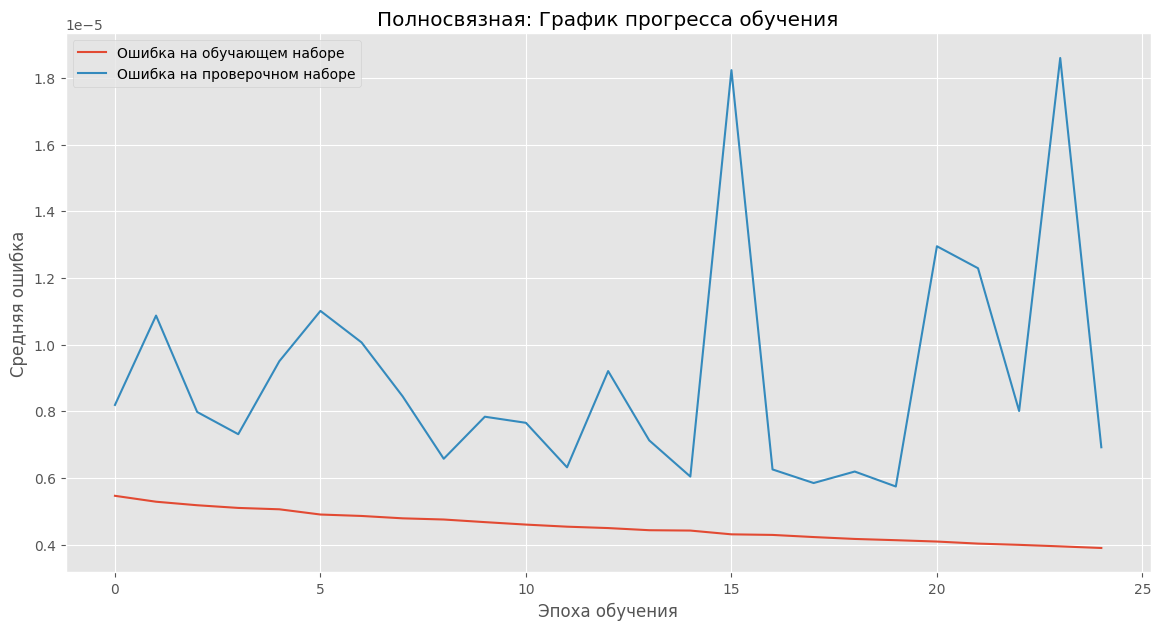

910/910 [==============================] - 5s 5ms/step


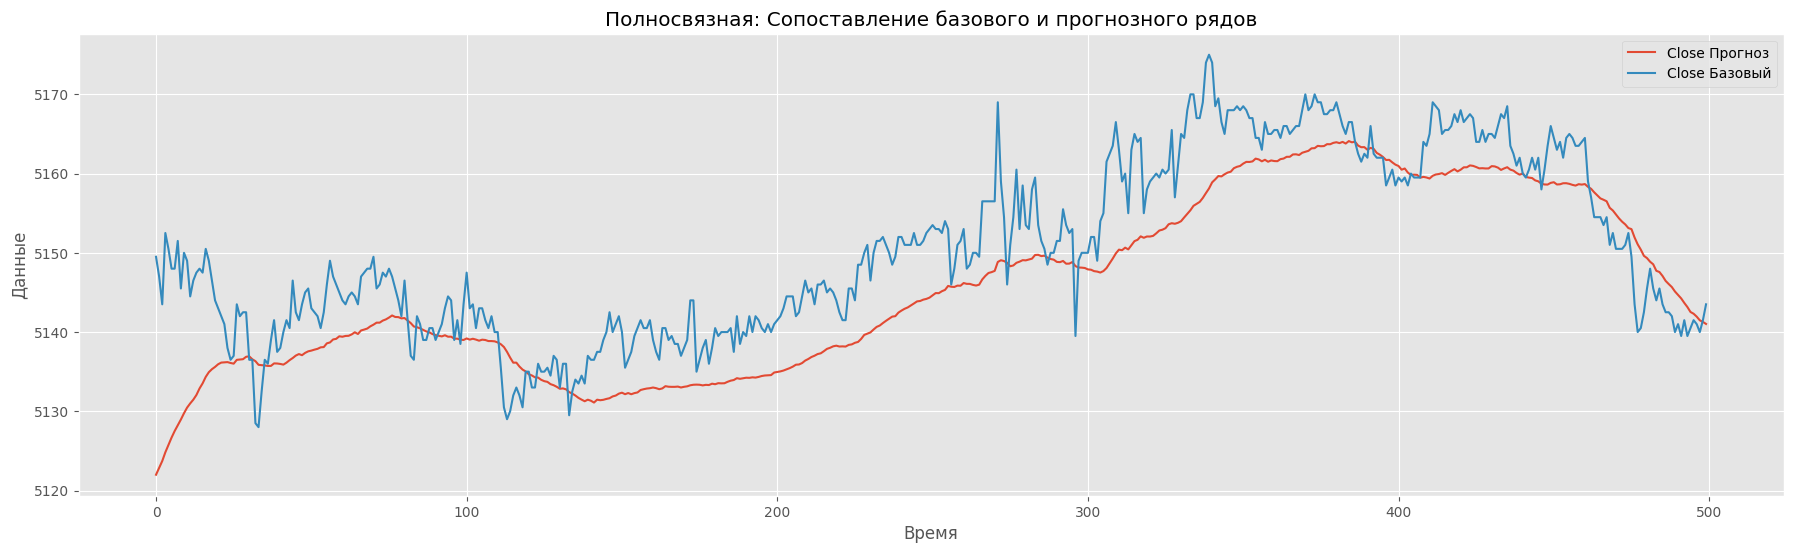

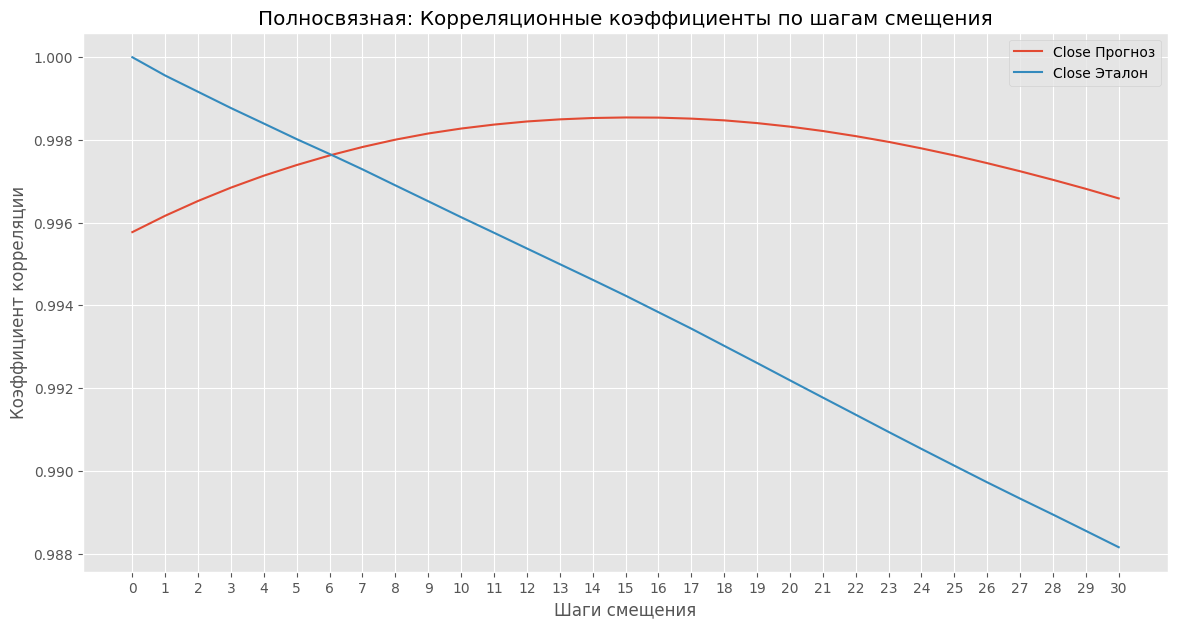

Обучение 25 эпох
Epoch 1/25
22579/22579 [==============================] - 239s 11ms/step - loss: 3.3643e-06 - val_loss: 5.4037e-06
Epoch 2/25
22579/22579 [==============================] - 238s 11ms/step - loss: 3.3643e-06 - val_loss: 5.4975e-06
Epoch 3/25
22579/22579 [==============================] - 245s 11ms/step - loss: 3.3575e-06 - val_loss: 5.7007e-06
Epoch 4/25
22579/22579 [==============================] - 240s 11ms/step - loss: 3.3497e-06 - val_loss: 5.3942e-06
Epoch 5/25
22579/22579 [==============================] - 246s 11ms/step - loss: 3.3522e-06 - val_loss: 5.5720e-06
Epoch 6/25
22579/22579 [==============================] - 247s 11ms/step - loss: 3.3455e-06 - val_loss: 5.3549e-06
Epoch 7/25
22579/22579 [==============================] - 242s 11ms/step - loss: 3.3403e-06 - val_loss: 5.6193e-06
Epoch 8/25
22579/22579 [==============================] - 245s 11ms/step - loss: 3.3292e-06 - val_loss: 5.4924e-06
Epoch 9/25
22579/22579 [==============================] - 241s 

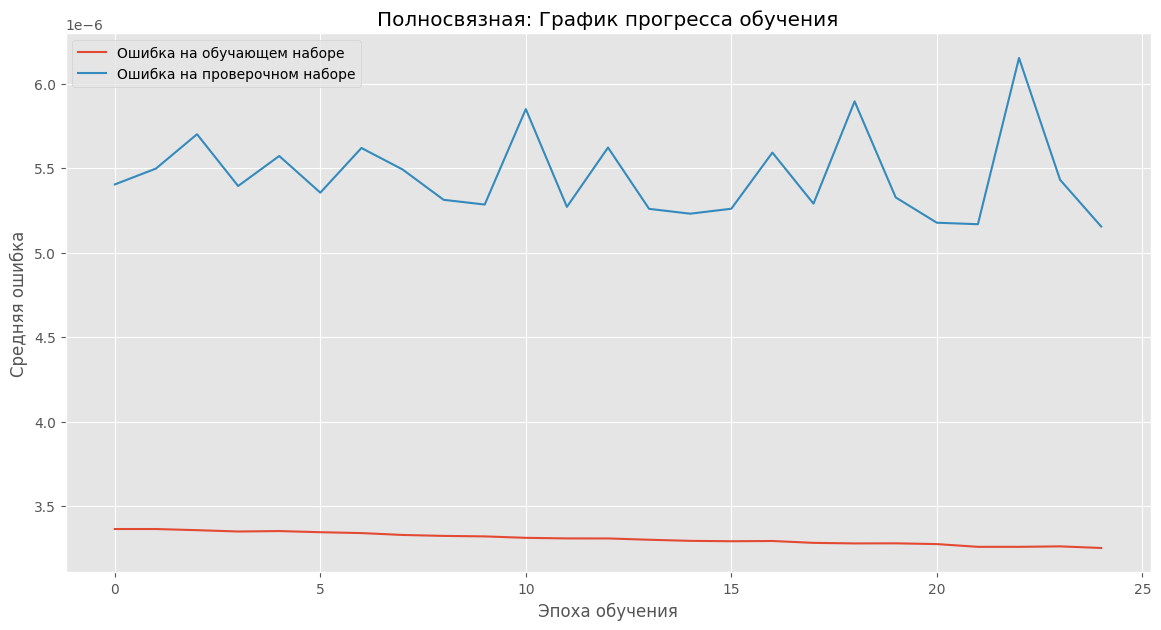

910/910 [==============================] - 6s 6ms/step


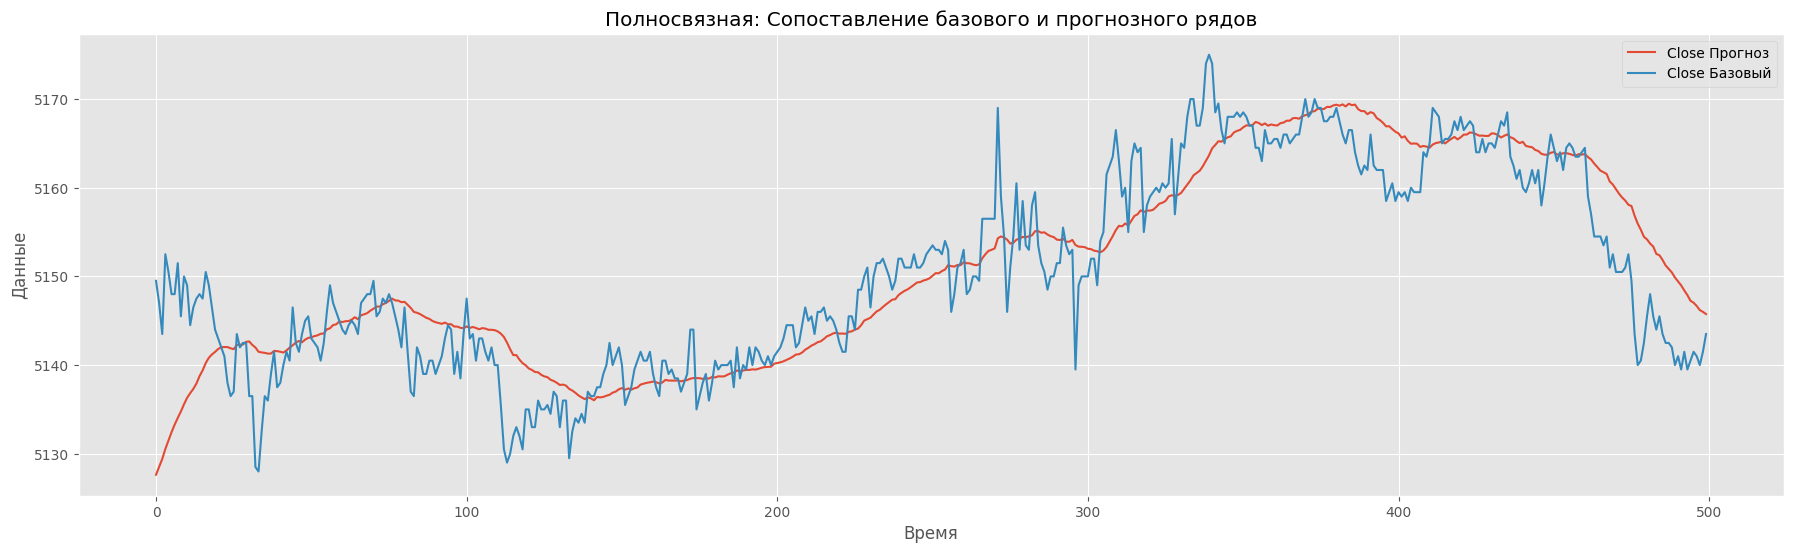

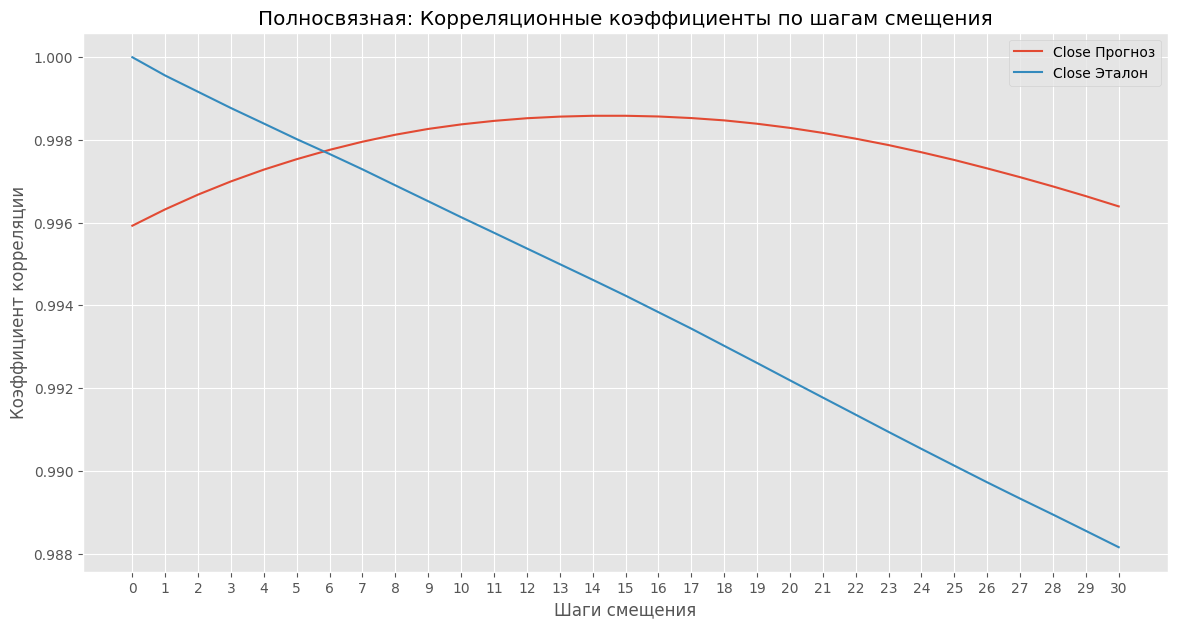

In [ ]:
model_dense = Sequential() # Модель MLP

model_dense.add(Dense(150, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

from tensorflow.keras.optimizers import Adam

train_eval_net(model_dense, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-4)),
                                                         (25, Adam(learning_rate =1e-5)),
                                                         (25, Adam(learning_rate =1e-6))],
               title='Полносвязная', x_test=x_test, y_test=y_test, y_scaler=y_scaler)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 296, 64)           1664      
                                                                 
 conv1d_3 (Conv1D)           (None, 292, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 146, 64)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9344)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               934500    
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                      

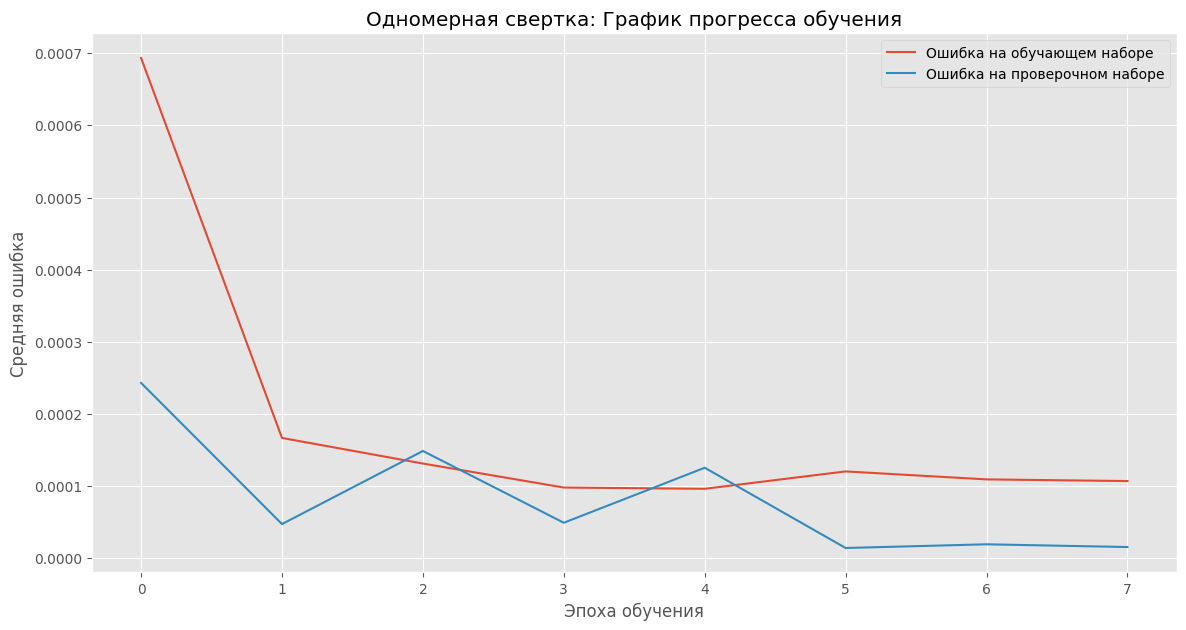

910/910 [==============================] - 15s 16ms/step


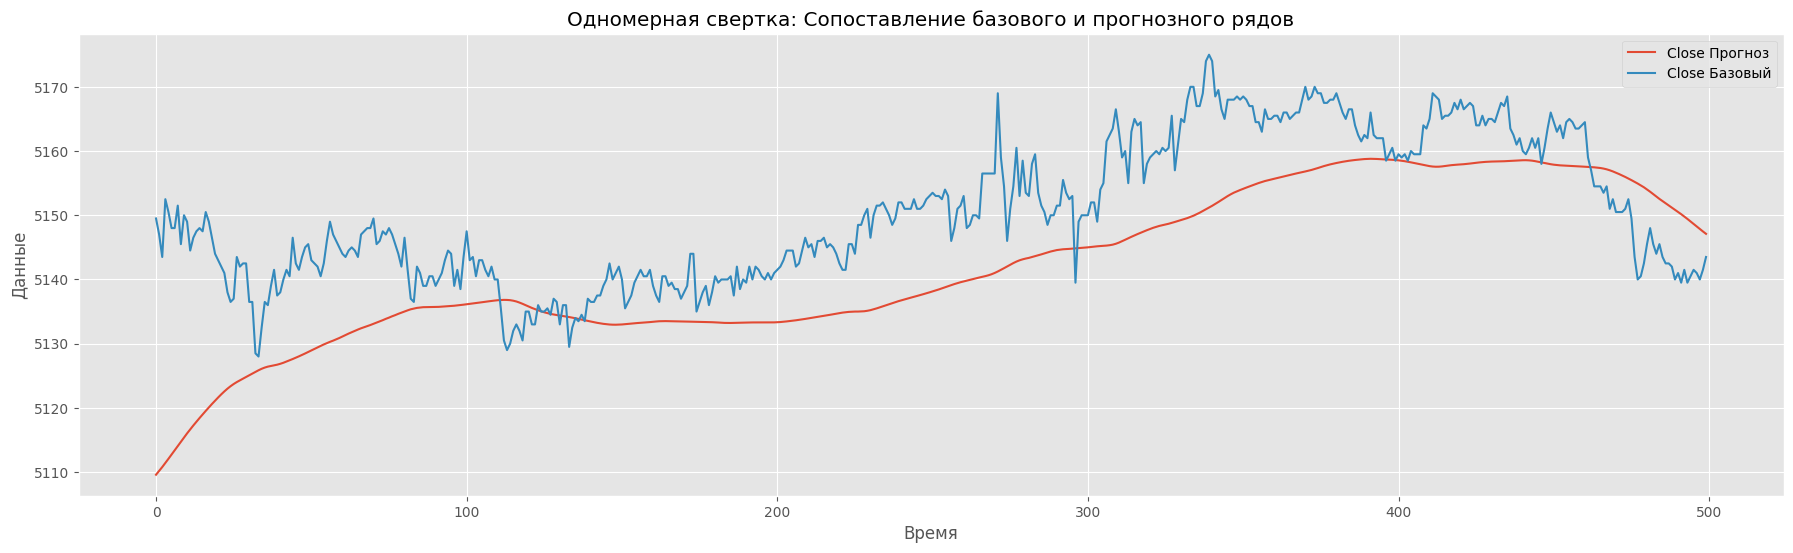

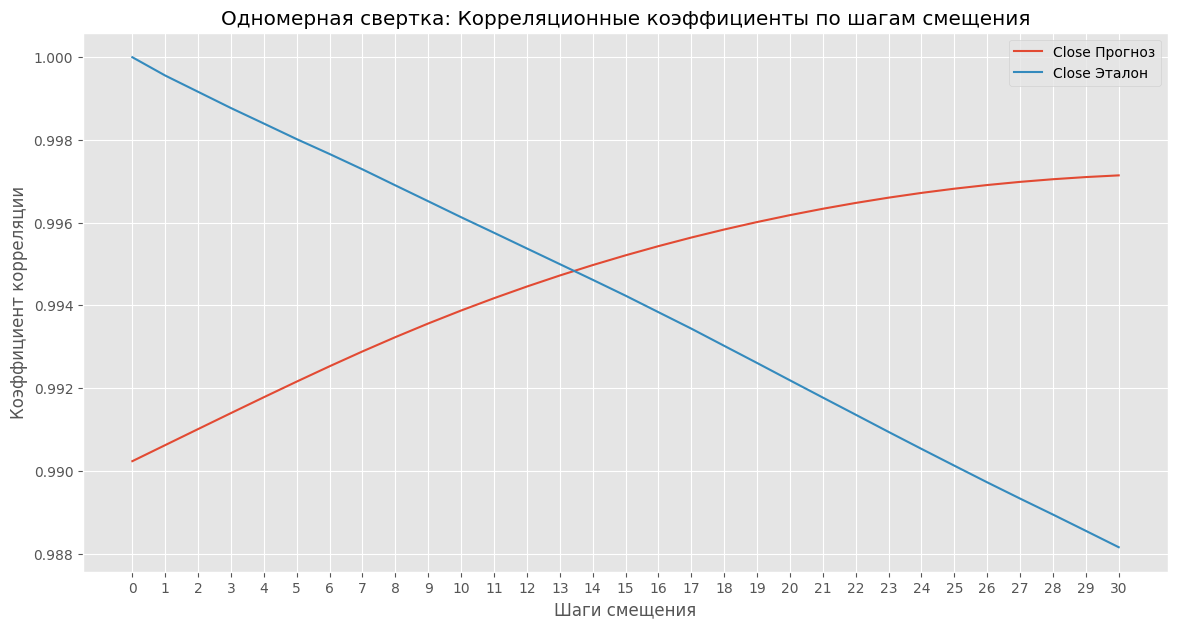

Обучение 5 эпох
Epoch 1/5
22579/22579 [==============================] - 1094s 48ms/step - loss: 9.2975e-05 - val_loss: 1.2044e-05
Epoch 2/5
22579/22579 [==============================] - 1079s 48ms/step - loss: 1.0002e-04 - val_loss: 2.3579e-05
Epoch 3/5
22579/22579 [==============================] - 1079s 48ms/step - loss: 1.0053e-04 - val_loss: 2.4158e-04
Epoch 4/5
22579/22579 [==============================] - 1085s 48ms/step - loss: 1.0737e-04 - val_loss: 5.7375e-05
Epoch 5/5
22579/22579 [==============================] - 1081s 48ms/step - loss: 8.8417e-05 - val_loss: 3.6237e-04


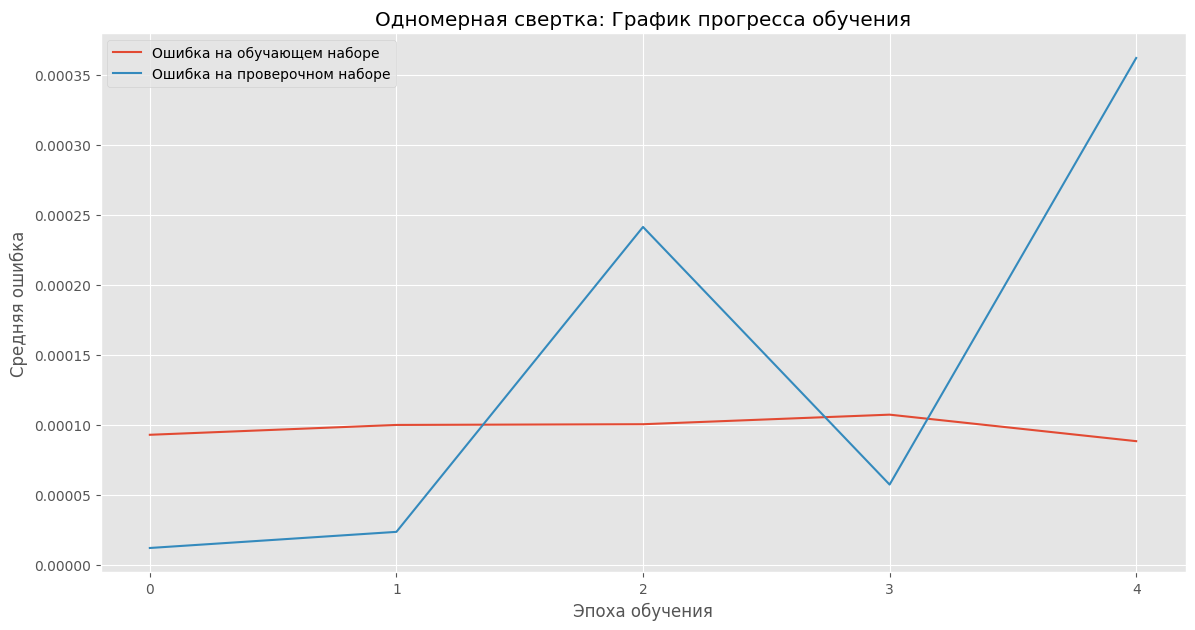

910/910 [==============================] - 16s 17ms/step


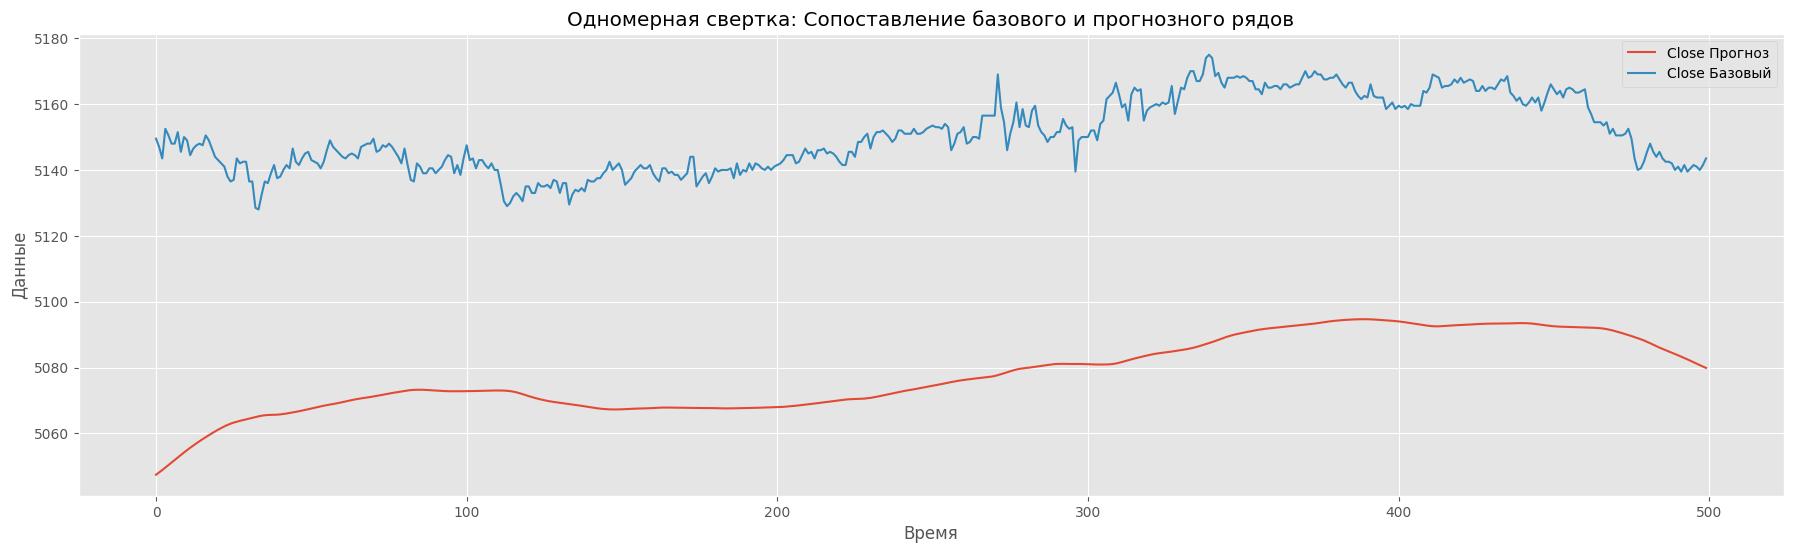

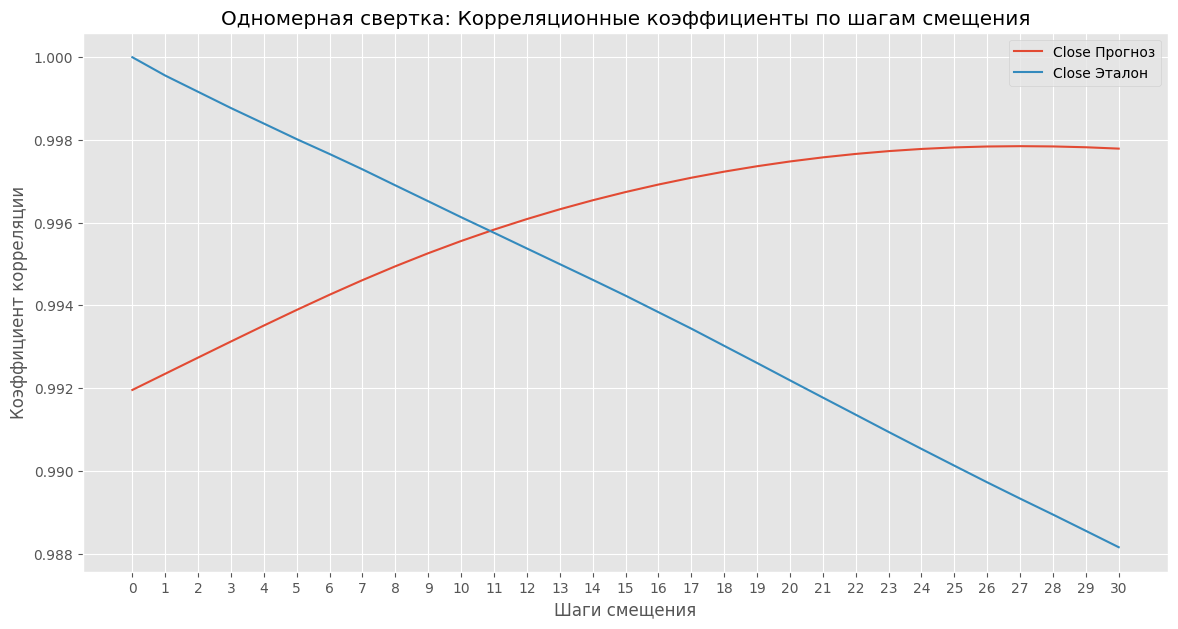

In [ ]:
model_conv = Sequential() # Модель Conv1D
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))

train_eval_net(model_conv, train_datagen, val_datagen, [(8, Adam(lr=1e-4)),
                                                        (5, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 220       
                                                                 
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________
Обучение 5 эпох
Epoch 1/5
22579/22579 [==============================] - 1498s 66ms/step - loss: 6.1139e-04 - val_loss: 5.2109e-06
Epoch 2/5
22579/22579 [==============================] - 1543s 68ms/step - loss: 1.3004e-05 - val_loss: 2.0618e-06
Epoch 3/5
22579/22579 [==============================] - 1488s 66ms/step - l

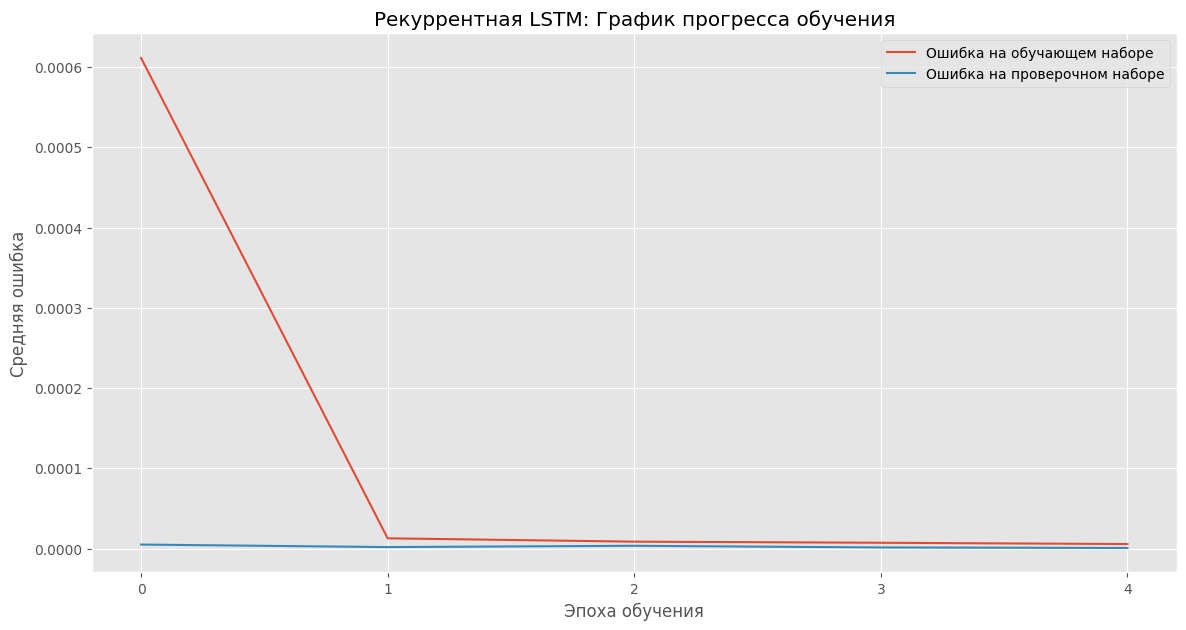

910/910 [==============================] - 13s 13ms/step


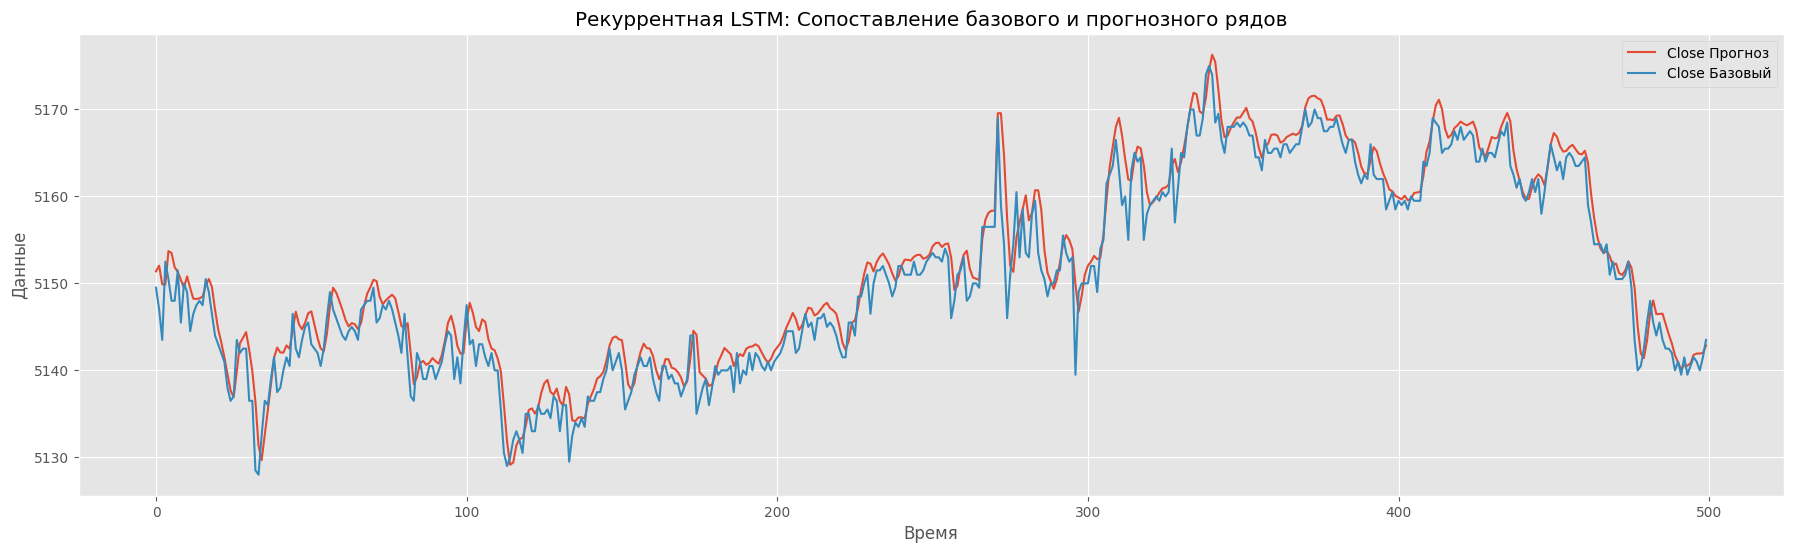

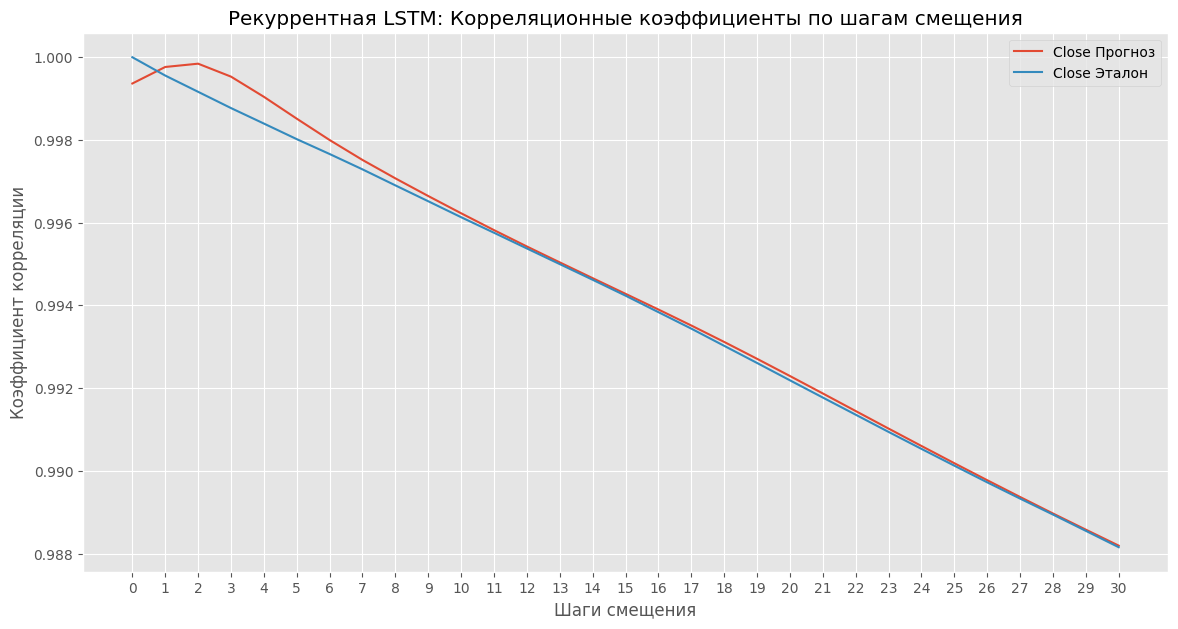

In [ ]:
model_lstm = Sequential()  # Модель LSTM
model_lstm.add(LSTM(5, input_shape=x_test.shape[1:]))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(y_test.shape[1], activation='linear'))

train_eval_net(model_lstm, train_datagen, val_datagen, [(5, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Рекуррентная LSTM')

**Задание 1.**

В задании используется база курса акций.
1.	Создайте и  обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.
2.	Создайте и обучите сверточную сеть на прогнозирование на 1 шаг вперёд прямым способом и визуализируйте результат.
3.	Вычислите значения  коэффициентов корреляции базового ряда и предсказанного с разным смещением.  Выведите графики коэффициентов корреляции
4.	Сделайте то же задание с сетью, которая будет использовать  LSTM слои.
5.  Выведите лучшую архитектуру сети.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, Dropout

In [ ]:
import pandas as pd

file_path = 'GAZP_180610_230610.csv'

df = pd.read_csv(file_path, sep=';')

df['<CLOSE>'] = pd.to_numeric(df['<CLOSE>'], errors='coerce')
df = df.dropna(subset=['<CLOSE>'])

df = df.reset_index(drop=True)

df[['<DATE>', '<TIME>', '<CLOSE>']].head()

,<DATE>,<TIME>,<CLOSE>
0,20180611,110000,142.00
1,20180611,120000,142.74
2,20180611,130000,141.88
3,20180611,140000,142.11
4,20180611,150000,141.93


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

close_prices = df['<CLOSE>'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

def create_dataset(series, window_size=10):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_dataset(scaled_prices, window_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train.shape, y_train.shape


((11538, 10, 1), (11538, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


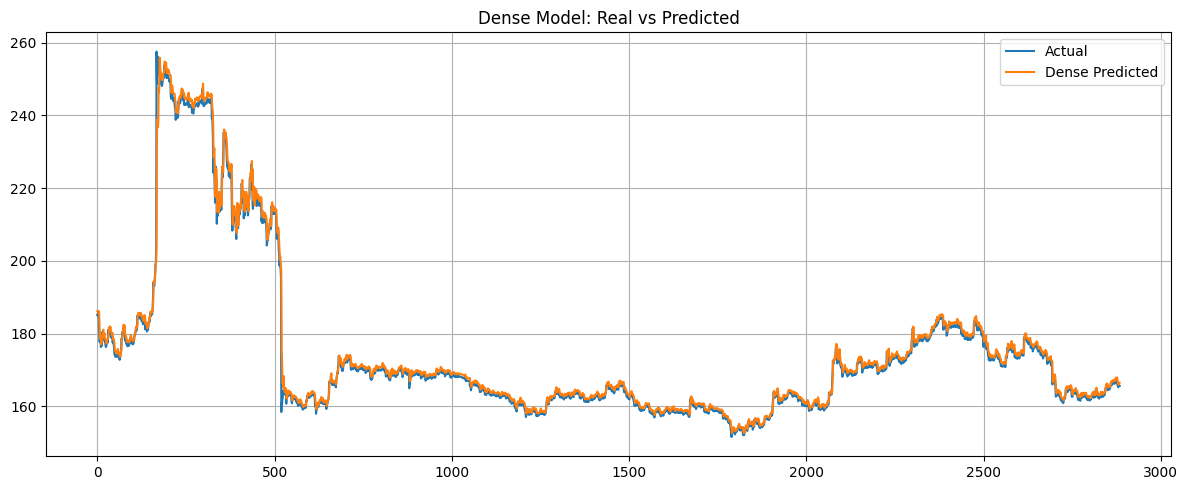

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

dense_model = Sequential([
    Flatten(input_shape=(window_size, 1)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

dense_model.compile(optimizer='adam', loss='mse')
history = dense_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)

y_pred_dense = dense_model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_dense_inv = scaler.inverse_transform(y_pred_dense)

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_dense_inv, label='Dense Predicted')
plt.title('Dense Model: Real vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2299e-04 - val_loss: 0.0021
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3473e-04 - val_loss: 0.0020
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2541e-04 - val_loss: 0.0020
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1958e-04 - val_loss: 0.0019
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0749e-04 - val_loss: 0.0017
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0332e-04 - val_loss: 0.0016
Epoch 8/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5093e-05 - val_loss: 0.0015
Epoch 9/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9646e-05 - val_loss: 0.0014
Epoch 10/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9988e-05 - val_loss: 0.0013
Epoch 11/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9240e-05 - val_loss: 0.0012
Epoch 12/20
325/325 ━━━

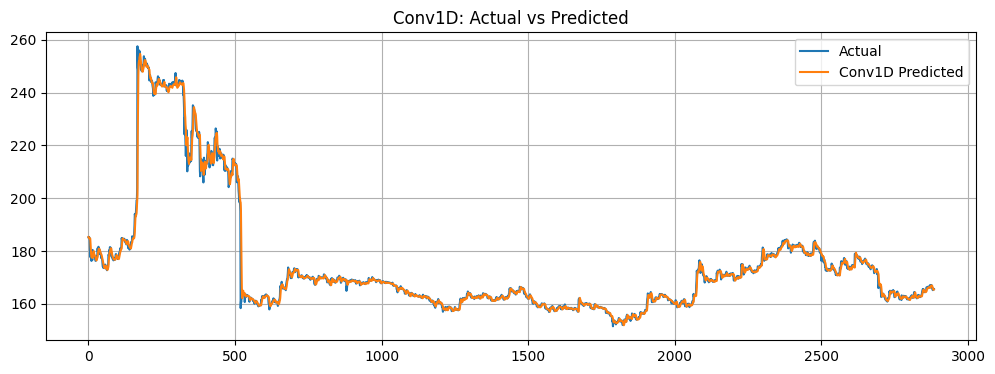

In [ ]:
conv_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(window_size,1)),
    MaxPooling1D(pool_size=2),
    Conv1D(16, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1)
])
conv_model.compile(optimizer='adam', loss='mse')
conv_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

y_pred_conv = conv_model.predict(X_test)
y_pred_conv_inv = scaler.inverse_transform(y_pred_conv)

plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_conv_inv, label='Conv1D Predicted')
plt.title('Conv1D: Actual vs Predicted')
plt.legend(); plt.grid(True)
plt.show()


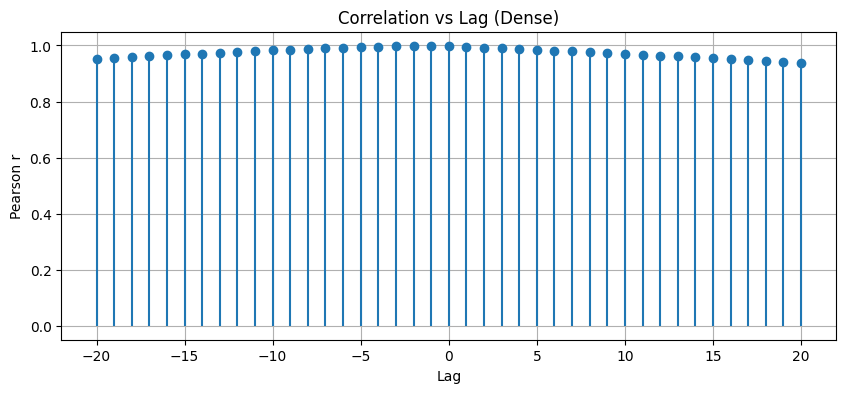

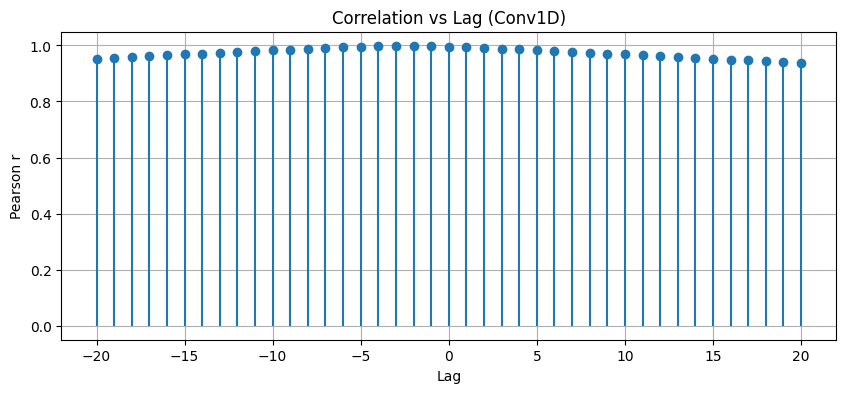

In [ ]:
def plot_correlations(y_true, y_pred, max_lag=20, title=''):
    lags = np.arange(-max_lag, max_lag+1)
    corrs = []
    for lag in lags:
        if lag < 0:
            corr, _ = pearsonr(y_true[:lag], y_pred[-lag:])
        elif lag > 0:
            corr, _ = pearsonr(y_true[lag:], y_pred[:-lag])
        else:
            corr, _ = pearsonr(y_true, y_pred)
        corrs.append(corr)
    plt.figure(figsize=(10,4))
    plt.stem(lags, corrs, basefmt=" ")
    plt.title(f'Correlation vs Lag ({title})')
    plt.xlabel('Lag')
    plt.ylabel('Pearson r')
    plt.grid(True)
    plt.show()
    return np.max(np.abs(corrs)), lags[np.argmax(np.abs(corrs))]

best_dense_corr, best_dense_lag = plot_correlations(y_test_inv.flatten(), y_pred_dense_inv.flatten(),
                                                   max_lag=20, title='Dense')
best_conv_corr, best_conv_lag   = plot_correlations(y_test_inv.flatten(), y_pred_conv_inv.flatten(),
                                                   max_lag=20, title='Conv1D')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0235 - val_loss: 0.0017
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.5780e-04 - val_loss: 0.0017
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.9746e-04 - val_loss: 0.0017
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.3971e-04 - val_loss: 0.0017
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1788e-04 - val_loss: 0.0016
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.9021e-04 - val_loss: 0.0016
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8853e-04 - val_loss: 0.0016
Epoch 8/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7697e-04 - val_loss: 0.0015
Epoch 9/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.6679e-04 - val_loss: 0.0015
Epoch 10/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6212e-04 - val_loss: 0.0014
Epoch 11/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.5041e-04 - val_loss: 0.0013
Epoch 12/20

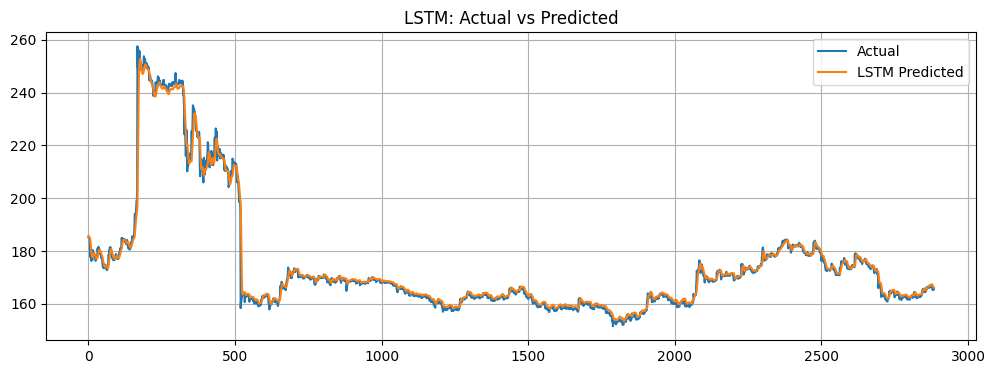

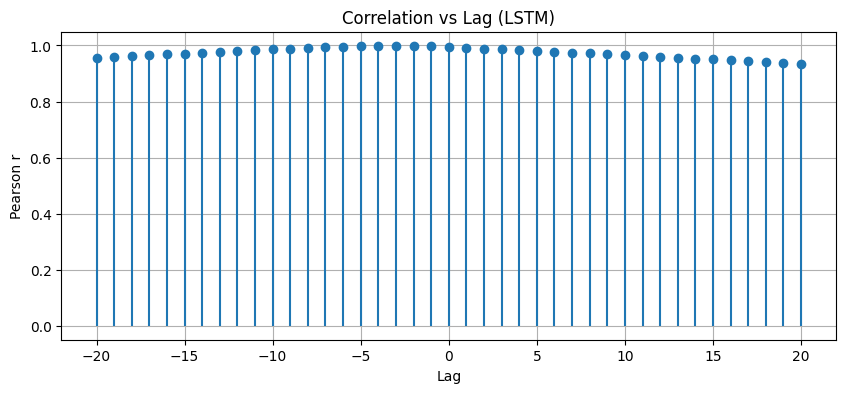

In [ ]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size,1)),
    Dropout(0.2),
    LSTM(25),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_lstm_inv, label='LSTM Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.legend(); plt.grid(True)
plt.show()

best_lstm_corr, best_lstm_lag = plot_correlations(y_test_inv.flatten(), y_pred_lstm_inv.flatten(),
                                                   max_lag=20, title='LSTM')

In [ ]:
results = {
    'Dense': {'corr': best_dense_corr, 'lag': best_dense_lag},
    'Conv1D': {'corr': best_conv_corr, 'lag': best_conv_lag},
    'LSTM': {'corr': best_lstm_corr, 'lag': best_lstm_lag},
}
best_arch = max(results.items(), key=lambda x: x[1]['corr'])

print("=== Результаты по моделям ===")
for name, v in results.items():
    print(f"{name}: max|corr|={v['corr']:.4f} при лаге {v['lag']}")

print(f"\nЛучшая архитектура: {best_arch[0]} (|corr|={best_arch[1]['corr']:.4f})")

=== Результаты по моделям ===
Dense: max|corr|=0.9991 при лаге -1
Conv1D: max|corr|=0.9990 при лаге -2
LSTM: max|corr|=0.9990 при лаге -3

Лучшая архитектура: Dense (|corr|=0.9991)


**Задание 2.**

1.	Создайте и обучите сеть для прогнозирования временного ряда Daily_Temperatures_1950-2023 и визуализируйте результат.
2.	Вычислите значения  коэффициентов корреляции базового ряда и предсказанного с разным смещением.  Выведите графики коэффициентов корреляции
3.	Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.
4.	Постройте графики сравнения предсказания с оригинальным сигналом.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

file_path = 'Daily_Temperatures_1950-2023.xls'
df = pd.read_excel(file_path)

df['Date'] = pd.to_datetime(df[['Year','Month','Day']])
df = df.sort_values('Date').reset_index(drop=True)

series = df['Tmean'].astype(float).values.reshape(-1,1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

def create_dataset_one_step(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

def create_dataset_multi_step(series, window_size, horizon):
    X, Y = [], []
    for i in range(len(series) - window_size - horizon + 1):
        X.append(series[i:i+window_size])
        Y.append(series[i+window_size:i+window_size+horizon].flatten())
    return np.array(X), np.array(Y)

window_size = 30    # предыдущие 30 дней
horizon = 10        # прогноз на 10 дней вперед


X1, y1 = create_dataset_one_step(series_scaled, window_size)
X10, y10 = create_dataset_multi_step(series_scaled, window_size, horizon)

split1 = int(0.8 * len(X1))
X1_train, X1_test = X1[:split1], X1[split1:]
y1_train, y1_test = y1[:split1], y1[split1:]

split10 = int(0.8 * len(X10))
X10_train, X10_test = X10[:split10], X10[split10:]
y10_train, y10_test = y10[:split10], y10[split10:]

In [ ]:
def build_lstm_model(output_size):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(window_size,1)),
        Dropout(0.2),
        LSTM(32),
        Dense(output_size)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0508 - val_loss: 0.0061
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss

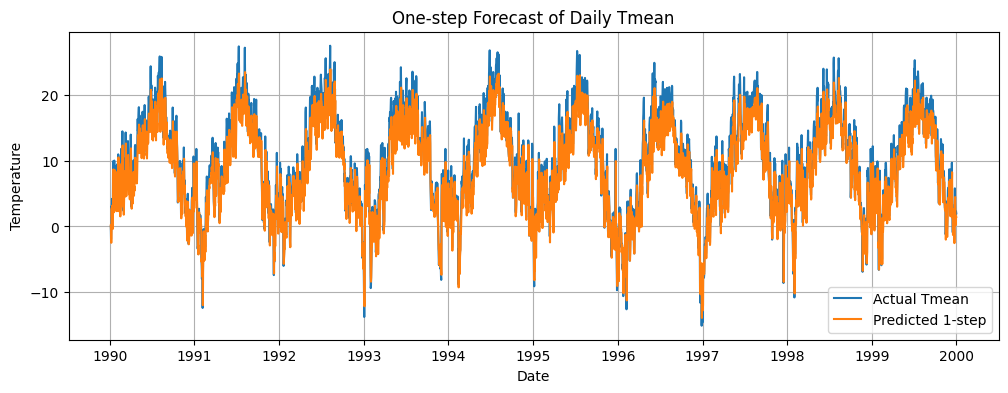

In [ ]:
model1 = build_lstm_model(1)
model1.fit(X1_train, y1_train,
           validation_split=0.1,
           epochs=30, batch_size=64, verbose=1)

y1_pred = model1.predict(X1_test)
y1_test_inv = scaler.inverse_transform(y1_test)
y1_pred_inv = scaler.inverse_transform(y1_pred)

plt.figure(figsize=(12,4))
plt.plot(df['Date'].values[split1+window_size:], y1_test_inv, label='Actual Tmean')
plt.plot(df['Date'].values[split1+window_size:], y1_pred_inv, label='Predicted 1-step')
plt.title('One-step Forecast of Daily Tmean')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend(); plt.grid(True)
plt.show()

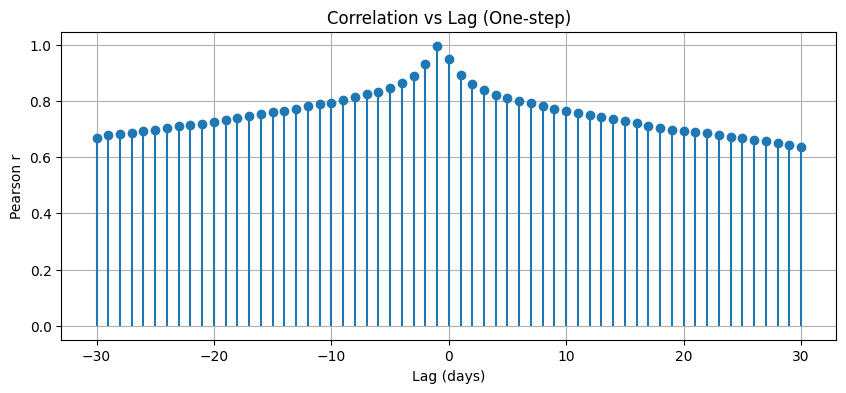

In [ ]:
def plot_corr(y_true, y_pred, max_lag=30, title=''):
    lags = np.arange(-max_lag, max_lag+1)
    corrs = []
    for lag in lags:
        if lag < 0:
            corr,_ = pearsonr(y_true[:lag], y_pred[-lag:])
        elif lag > 0:
            corr,_ = pearsonr(y_true[lag:], y_pred[:-lag])
        else:
            corr,_ = pearsonr(y_true, y_pred)
        corrs.append(corr)
    plt.figure(figsize=(10,4))
    plt.stem(lags, corrs, basefmt=" ")
    plt.title(f'Correlation vs Lag (One-step)')
    plt.xlabel('Lag (days)')
    plt.ylabel('Pearson r')
    plt.grid(True)
    plt.show()

plot_corr(y1_test_inv.flatten(), y1_pred_inv.flatten(), max_lag=30)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0593 - val_loss: 0.0092
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0085 - val_loss: 0.0093
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 5/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 6/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 7/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 8/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 9/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 10/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 11/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 12/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0

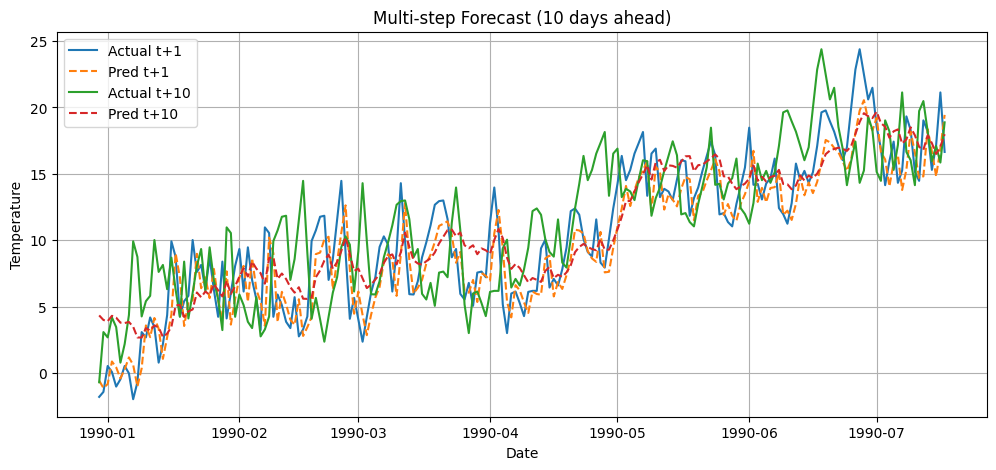

In [ ]:
model10 = build_lstm_model(horizon)
model10.fit(X10_train, y10_train,
            validation_split=0.1,
            epochs=30, batch_size=64, verbose=1)

y10_pred = model10.predict(X10_test)
y10_test_inv = scaler.inverse_transform(y10_test)
y10_pred_inv = scaler.inverse_transform(y10_pred)

n_plot = 200
dates10 = df['Date'].values[split10+window_size:split10+window_size+n_plot]
plt.figure(figsize=(12,5))
plt.plot(dates10, y10_test_inv[:n_plot, 0], label='Actual t+1')
plt.plot(dates10, y10_pred_inv[:n_plot, 0], '--', label='Pred t+1')
plt.plot(dates10, y10_test_inv[:n_plot, -1], label='Actual t+10')
plt.plot(dates10, y10_pred_inv[:n_plot, -1], '--', label='Pred t+10')
plt.title('Multi-step Forecast (10 days ahead)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend(); plt.grid(True)
plt.show()

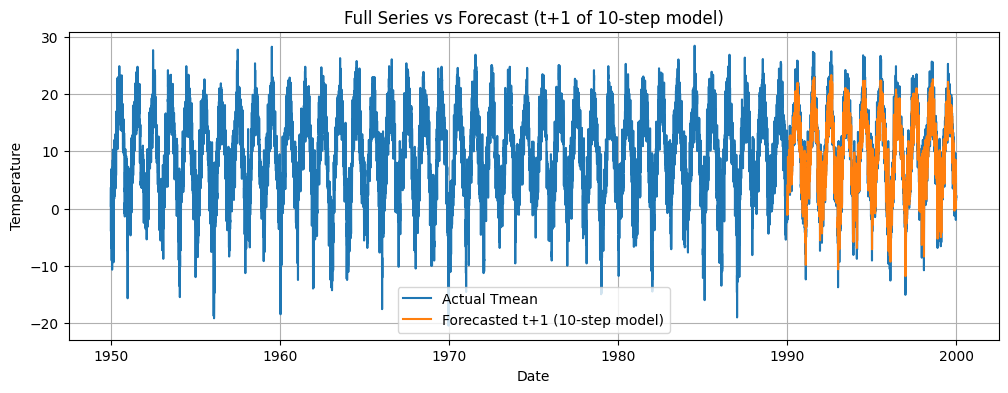

In [ ]:
forecast = np.full(len(series), np.nan)
for i in range(len(y10_pred_inv)):
    idx = split10 + window_size + i
    forecast[idx] = y10_pred_inv[i, 0]

forecast_dates = df['Date']
plt.figure(figsize=(12,4))
plt.plot(forecast_dates, series.flatten(), label='Actual Tmean')
plt.plot(forecast_dates, forecast, label='Forecasted t+1 (10-step model)')
plt.title('Full Series vs Forecast (t+1 of 10-step model)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend(); plt.grid(True)
plt.show()